In [32]:

import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import TargetEncoder
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from collections import Counter


In [33]:
def get_predictions_train(model, dataset):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels
    
    # Reset generator to start from the beginning
    dataset.reset()
  
    # Iterate over the dataset
    for _ in range(dataset.num_batches):
        image_batch, label_batch = next(dataset)
        # append true labels
        y_true.append(label_batch)
        # compute predictions
        preds = model.predict(image_batch, verbose=0)
        # append predicted labels
        y_pred.append(np.argmax(preds, axis=-1))

    # convert the true and predicted labels into tensors
    y_true = tf.concat([tf.convert_to_tensor(item) for item in y_true], axis=0)
    y_pred_classes = tf.concat([tf.convert_to_tensor(item) for item in y_pred], axis=0)
    class_labels = list(dataset.class_indices.keys())

    return y_true, y_pred_classes, class_labels

In [34]:
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [35]:
batch_size = 50 
img_size = (224, 224)
def count_images_in_classes(dataset):
    class_counts = Counter()
    for i in range(len(dataset)):
        _, labels = dataset[i]
        class_indices = np.argmax(labels, axis=1)
        class_counts.update(class_indices)
    return class_counts

print("Train_ds:")
train_ds = train_datagen.flow_from_directory(
    directory='bird_dataset/train',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=True)

class_names = {v: k for k, v in train_ds.class_indices.items()}

for index, count in count_images_in_classes(train_ds).items():
    print(f"  Trieda '{class_names[index]}': {count} obrázkov")
print("===================================")

print("Validation_ds:")
validation_ds = val_datagen.flow_from_directory(
    directory='bird_dataset/validation',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=False)

class_names = {v: k for k, v in validation_ds.class_indices.items()}

for index, count in count_images_in_classes(validation_ds).items():
    print(f"  Trieda '{class_names[index]}': {count} obrázkov")
print("===================================")

print("Test_ds:")
test_ds = test_datagen.flow_from_directory(
    directory='bird_dataset/test',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=False)
class_names = {v: k for k, v in test_ds.class_indices.items()}
for index, count in count_images_in_classes(test_ds).items():
    print(f"  Trieda '{class_names[index]}': {count} obrázkov")
print("===================================")



Train_ds:
Found 6400 images belonging to 200 classes.
  Trieda '157.Yellow_throated_Vireo': 32 obrázkov
  Trieda '011.Rusty_Blackbird': 32 obrázkov
  Trieda '133.White_throated_Sparrow': 32 obrázkov
  Trieda '174.Palm_Warbler': 32 obrázkov
  Trieda '068.Ruby_throated_Hummingbird': 32 obrázkov
  Trieda '063.Ivory_Gull': 32 obrázkov
  Trieda '038.Great_Crested_Flycatcher': 32 obrázkov
  Trieda '044.Frigatebird': 32 obrázkov
  Trieda '014.Indigo_Bunting': 32 obrázkov
  Trieda '058.Pigeon_Guillemot': 32 obrázkov
  Trieda '129.Song_Sparrow': 32 obrázkov
  Trieda '194.Cactus_Wren': 32 obrázkov
  Trieda '092.Nighthawk': 32 obrázkov
  Trieda '039.Least_Flycatcher': 32 obrázkov
  Trieda '139.Scarlet_Tanager': 32 obrázkov
  Trieda '153.Philadelphia_Vireo': 32 obrázkov
  Trieda '045.Northern_Fulmar': 32 obrázkov
  Trieda '091.Mockingbird': 32 obrázkov
  Trieda '007.Parakeet_Auklet': 32 obrázkov
  Trieda '079.Belted_Kingfisher': 32 obrázkov
  Trieda '142.Black_Tern': 32 obrázkov
  Trieda '067.Anna

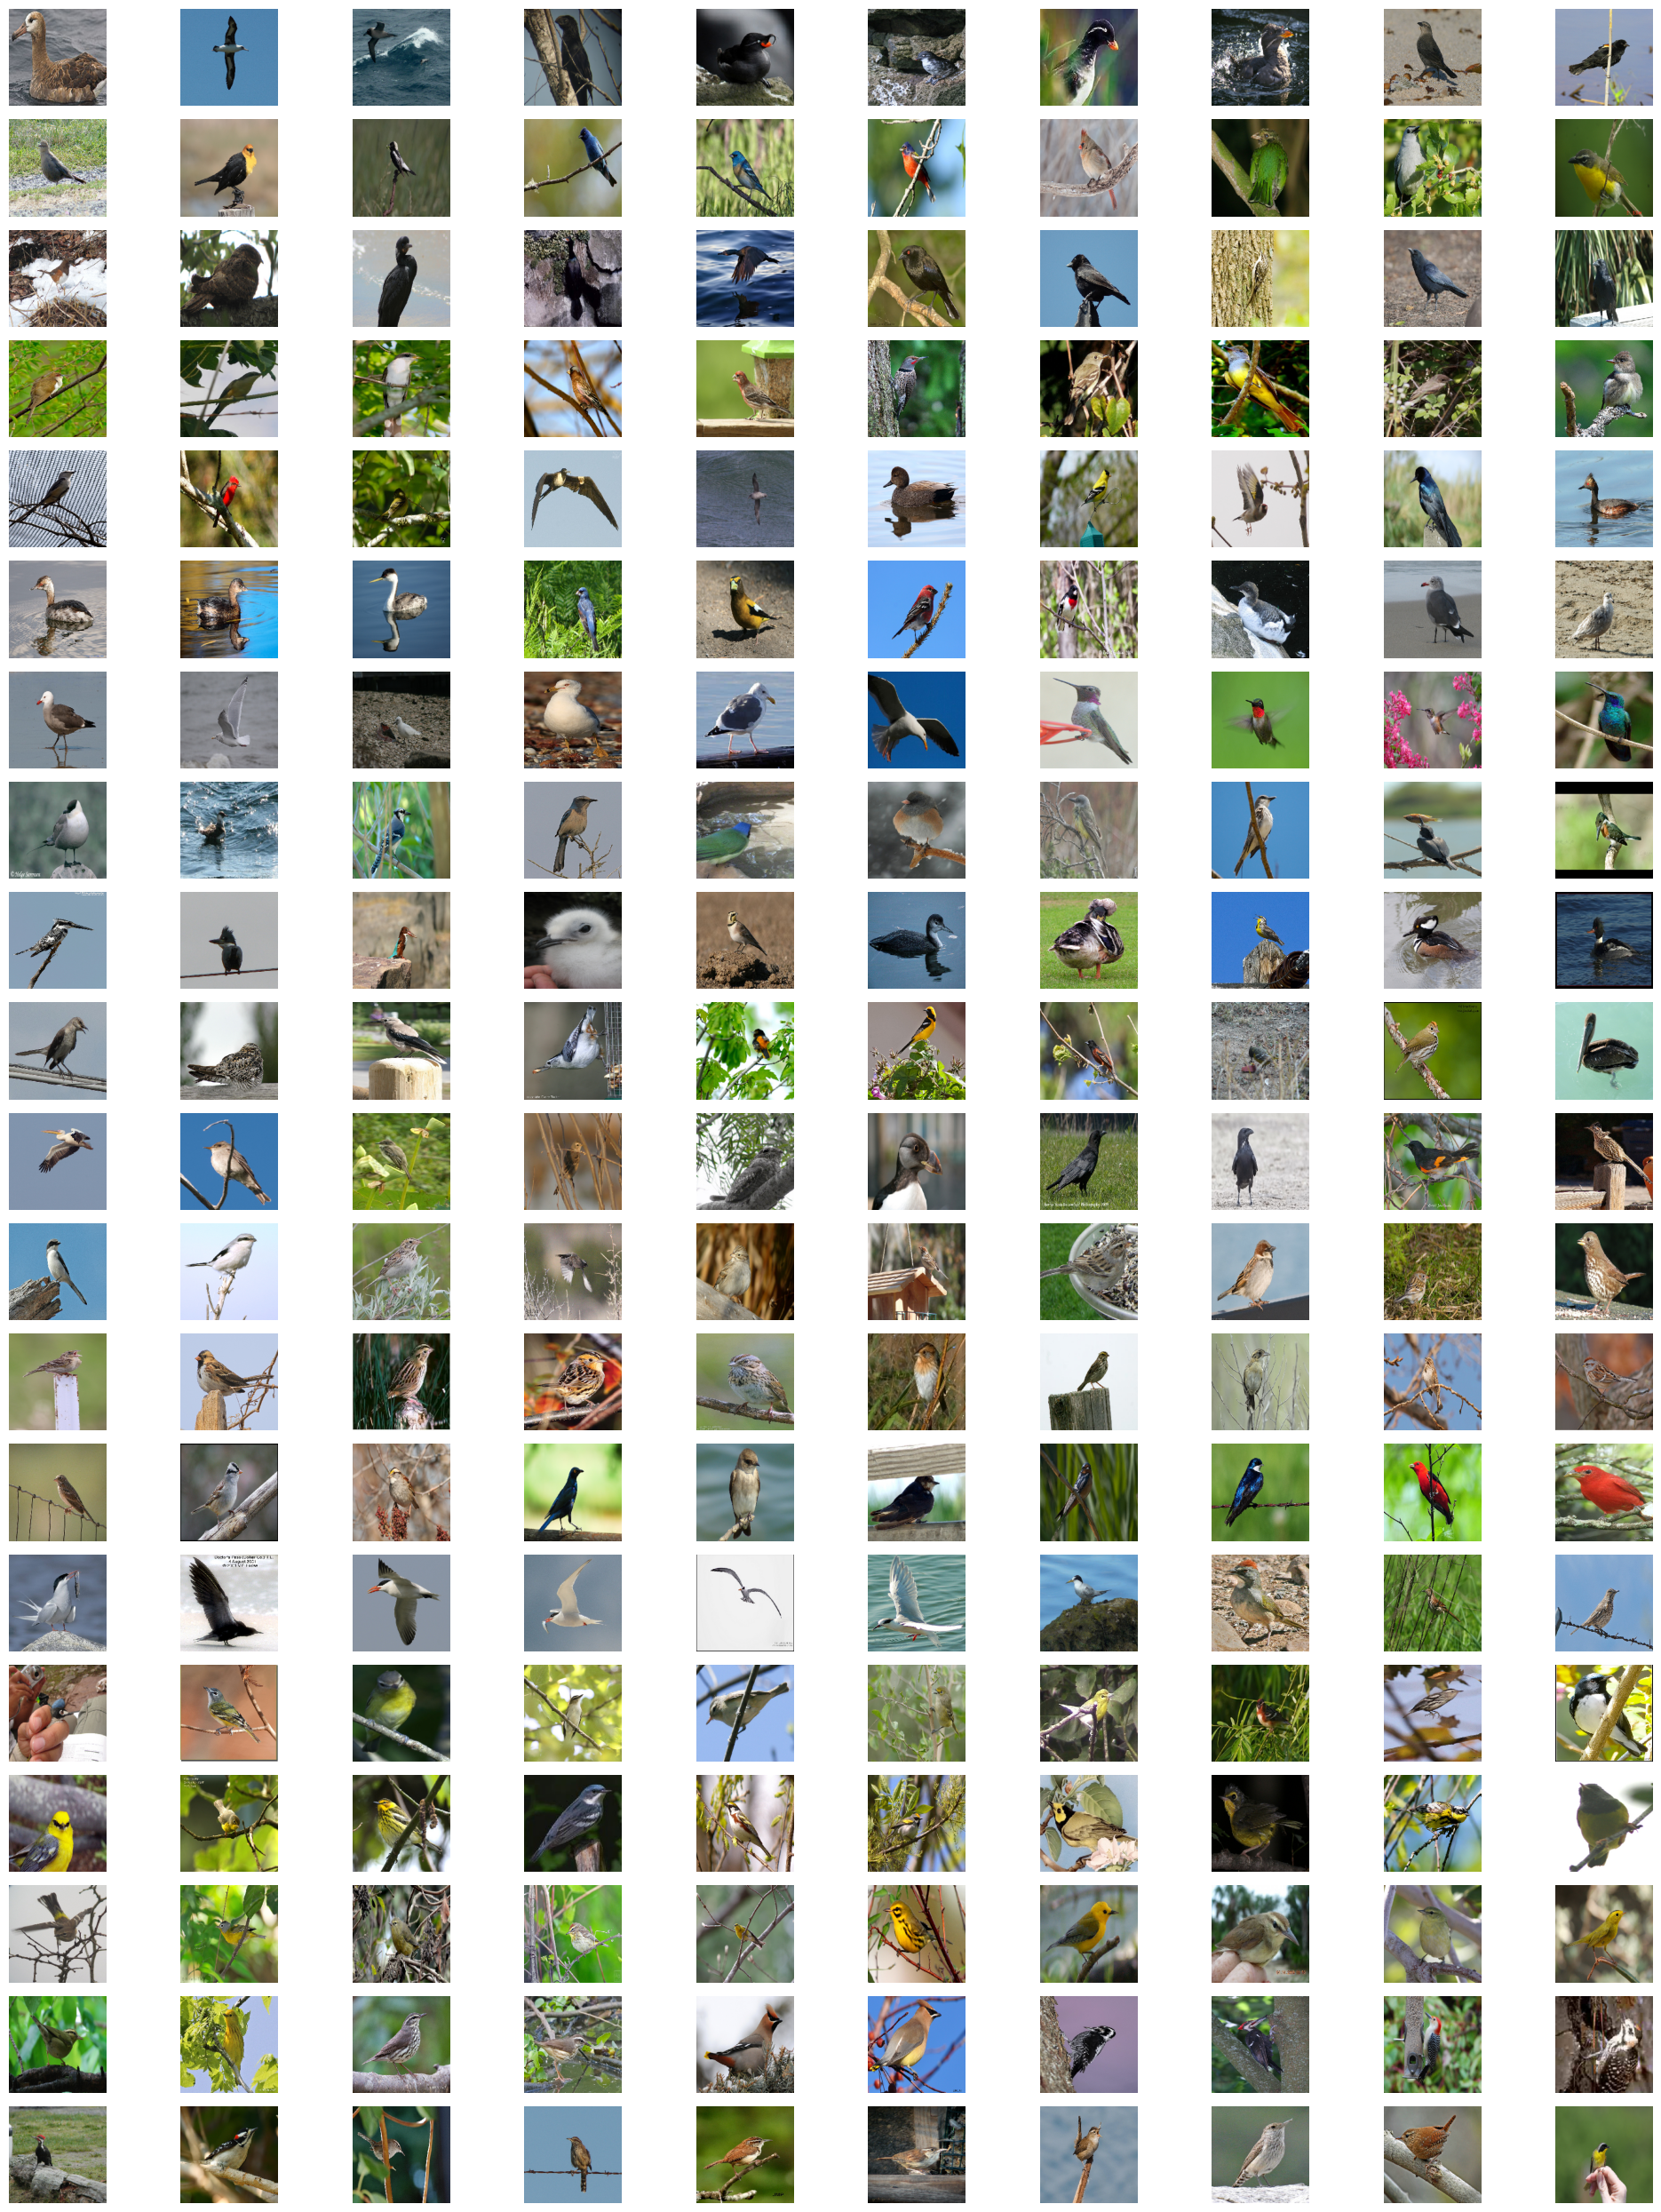

In [36]:

class_names = {v: k for k, v in train_ds.class_indices.items()}
representatives = {class_name: None for class_name in class_names.values()}

for images, labels in train_ds:
    for i in range(images.shape[0]):
        class_index = np.argmax(labels[i])
        class_name = class_names[class_index]
        if representatives[class_name] is None:
            representatives[class_name] = (images[i] * 255).astype("uint8") 
            
    if all(image is not None for image in representatives.values()):
        break

plt.figure(figsize=(20, 25))
for i, (class_name, image) in enumerate(representatives.items()):
    plt.subplot(20, 10, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.axis("off")
plt.tight_layout()
plt.show()

In [42]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
model = keras.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(tf.keras.layers.Dropout(0.05))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(200, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, epochs=20, verbose=1, validation_data=validation_ds, callbacks=[early_stopping])

loss, accurracy = model.evaluate(test_ds)
train_loss, train_accurracy = model.evaluate(train_ds)
print(f'Test accuracy: {accurracy:.4f}')
print(f'Training accuracy: {train_accurracy:.4f}')

Num GPUs Available:  1


/home/des/suns/env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.0048 - loss: 5.7759 - val_accuracy: 0.0050 - val_loss: 5.2983
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.0053 - loss: 5.2985 - val_accuracy: 0.0037 - val_loss: 5.2852
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.0054 - loss: 5.2770 - val_accuracy: 0.0137 - val_loss: 5.2450
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.0129 - loss: 5.2048 - val_accuracy: 0.0188 - val_loss: 5.0991
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.0259 - loss: 4.9755 - val_accuracy: 0.0200 - val_loss: 4.9151
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.0415 - loss: 4.6721 - val_accuracy: 0.0300 - val_loss: 4.8343
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.0745 - loss: 4.3303 - val_accuracy: 0.0312 - val_loss: 4.8870
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.1228 - loss: 3.9478 - 

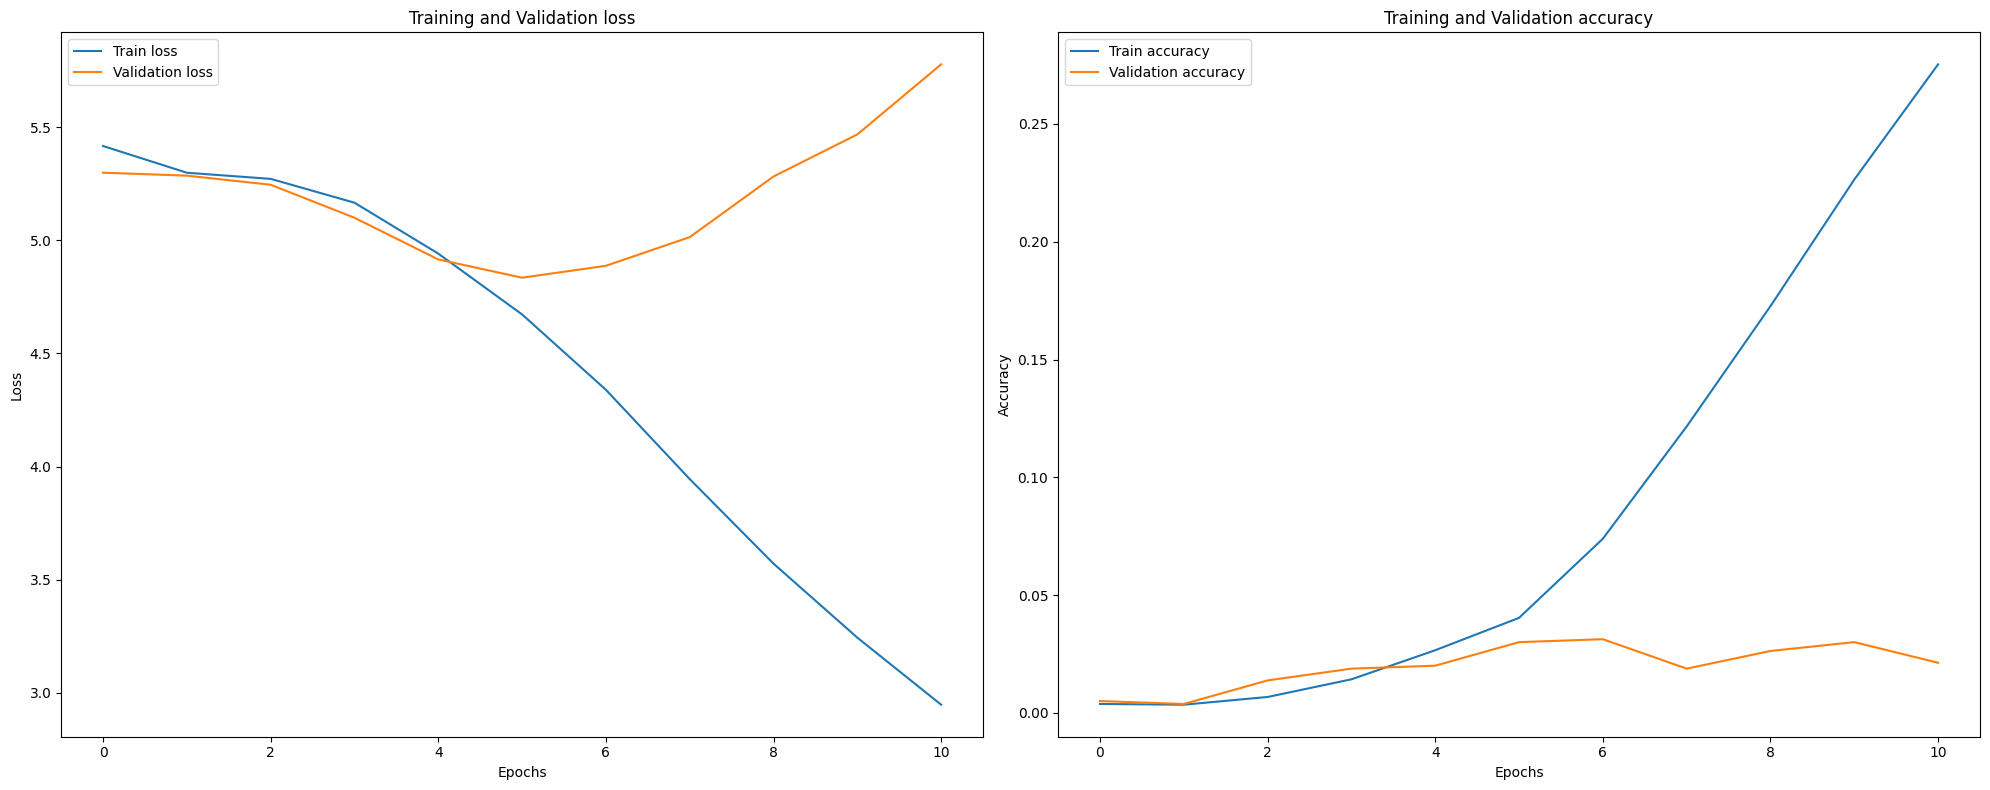

In [43]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label="Train loss")
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], label="Train accuracy")
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
y_true, y_pred_classes, class_labels = get_predictions_train(model, train_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step


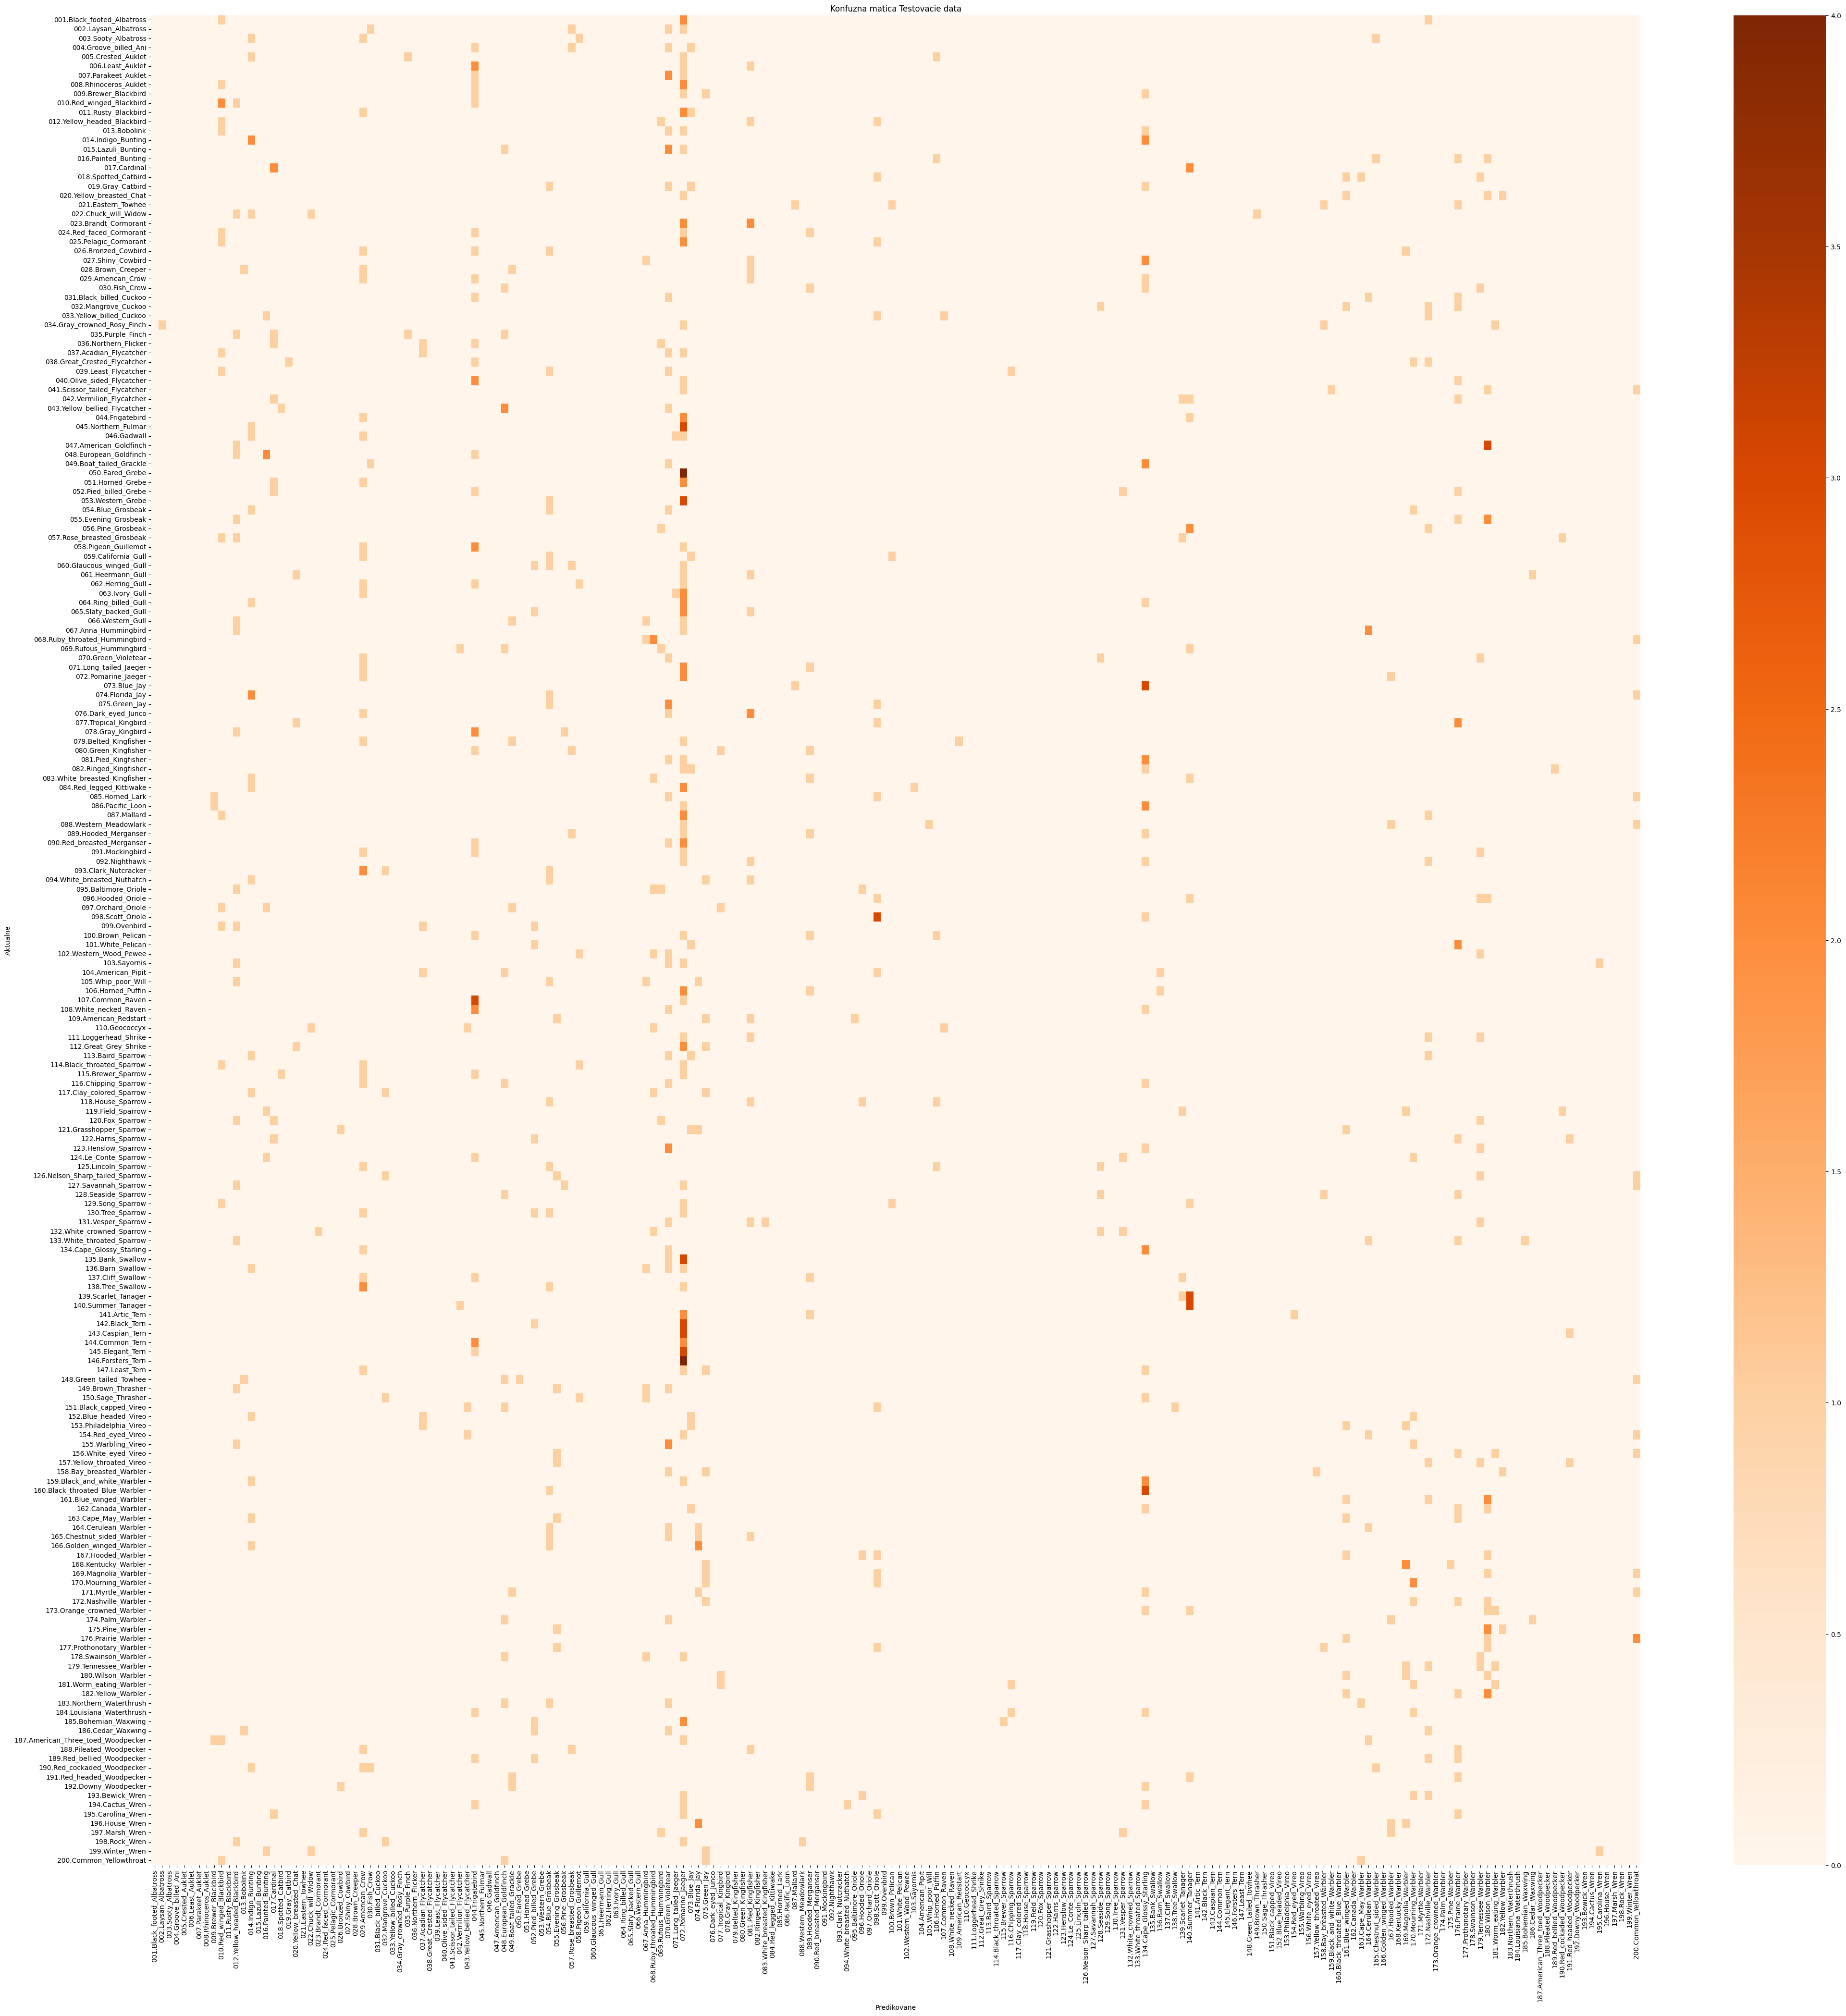

In [45]:
y_pred = np.argmax(model.predict(test_ds), axis=1) 
y_true_test = test_ds.classes
conf_matrix = confusion_matrix(y_true_test, y_pred)

plt.figure(figsize=(50,50))

sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Oranges', xticklabels=test_ds.class_indices.keys(), yticklabels=test_ds.class_indices.keys())
plt.title("Konfuzna matica Testovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")

plt.show()


Train accuracy: 0.1044


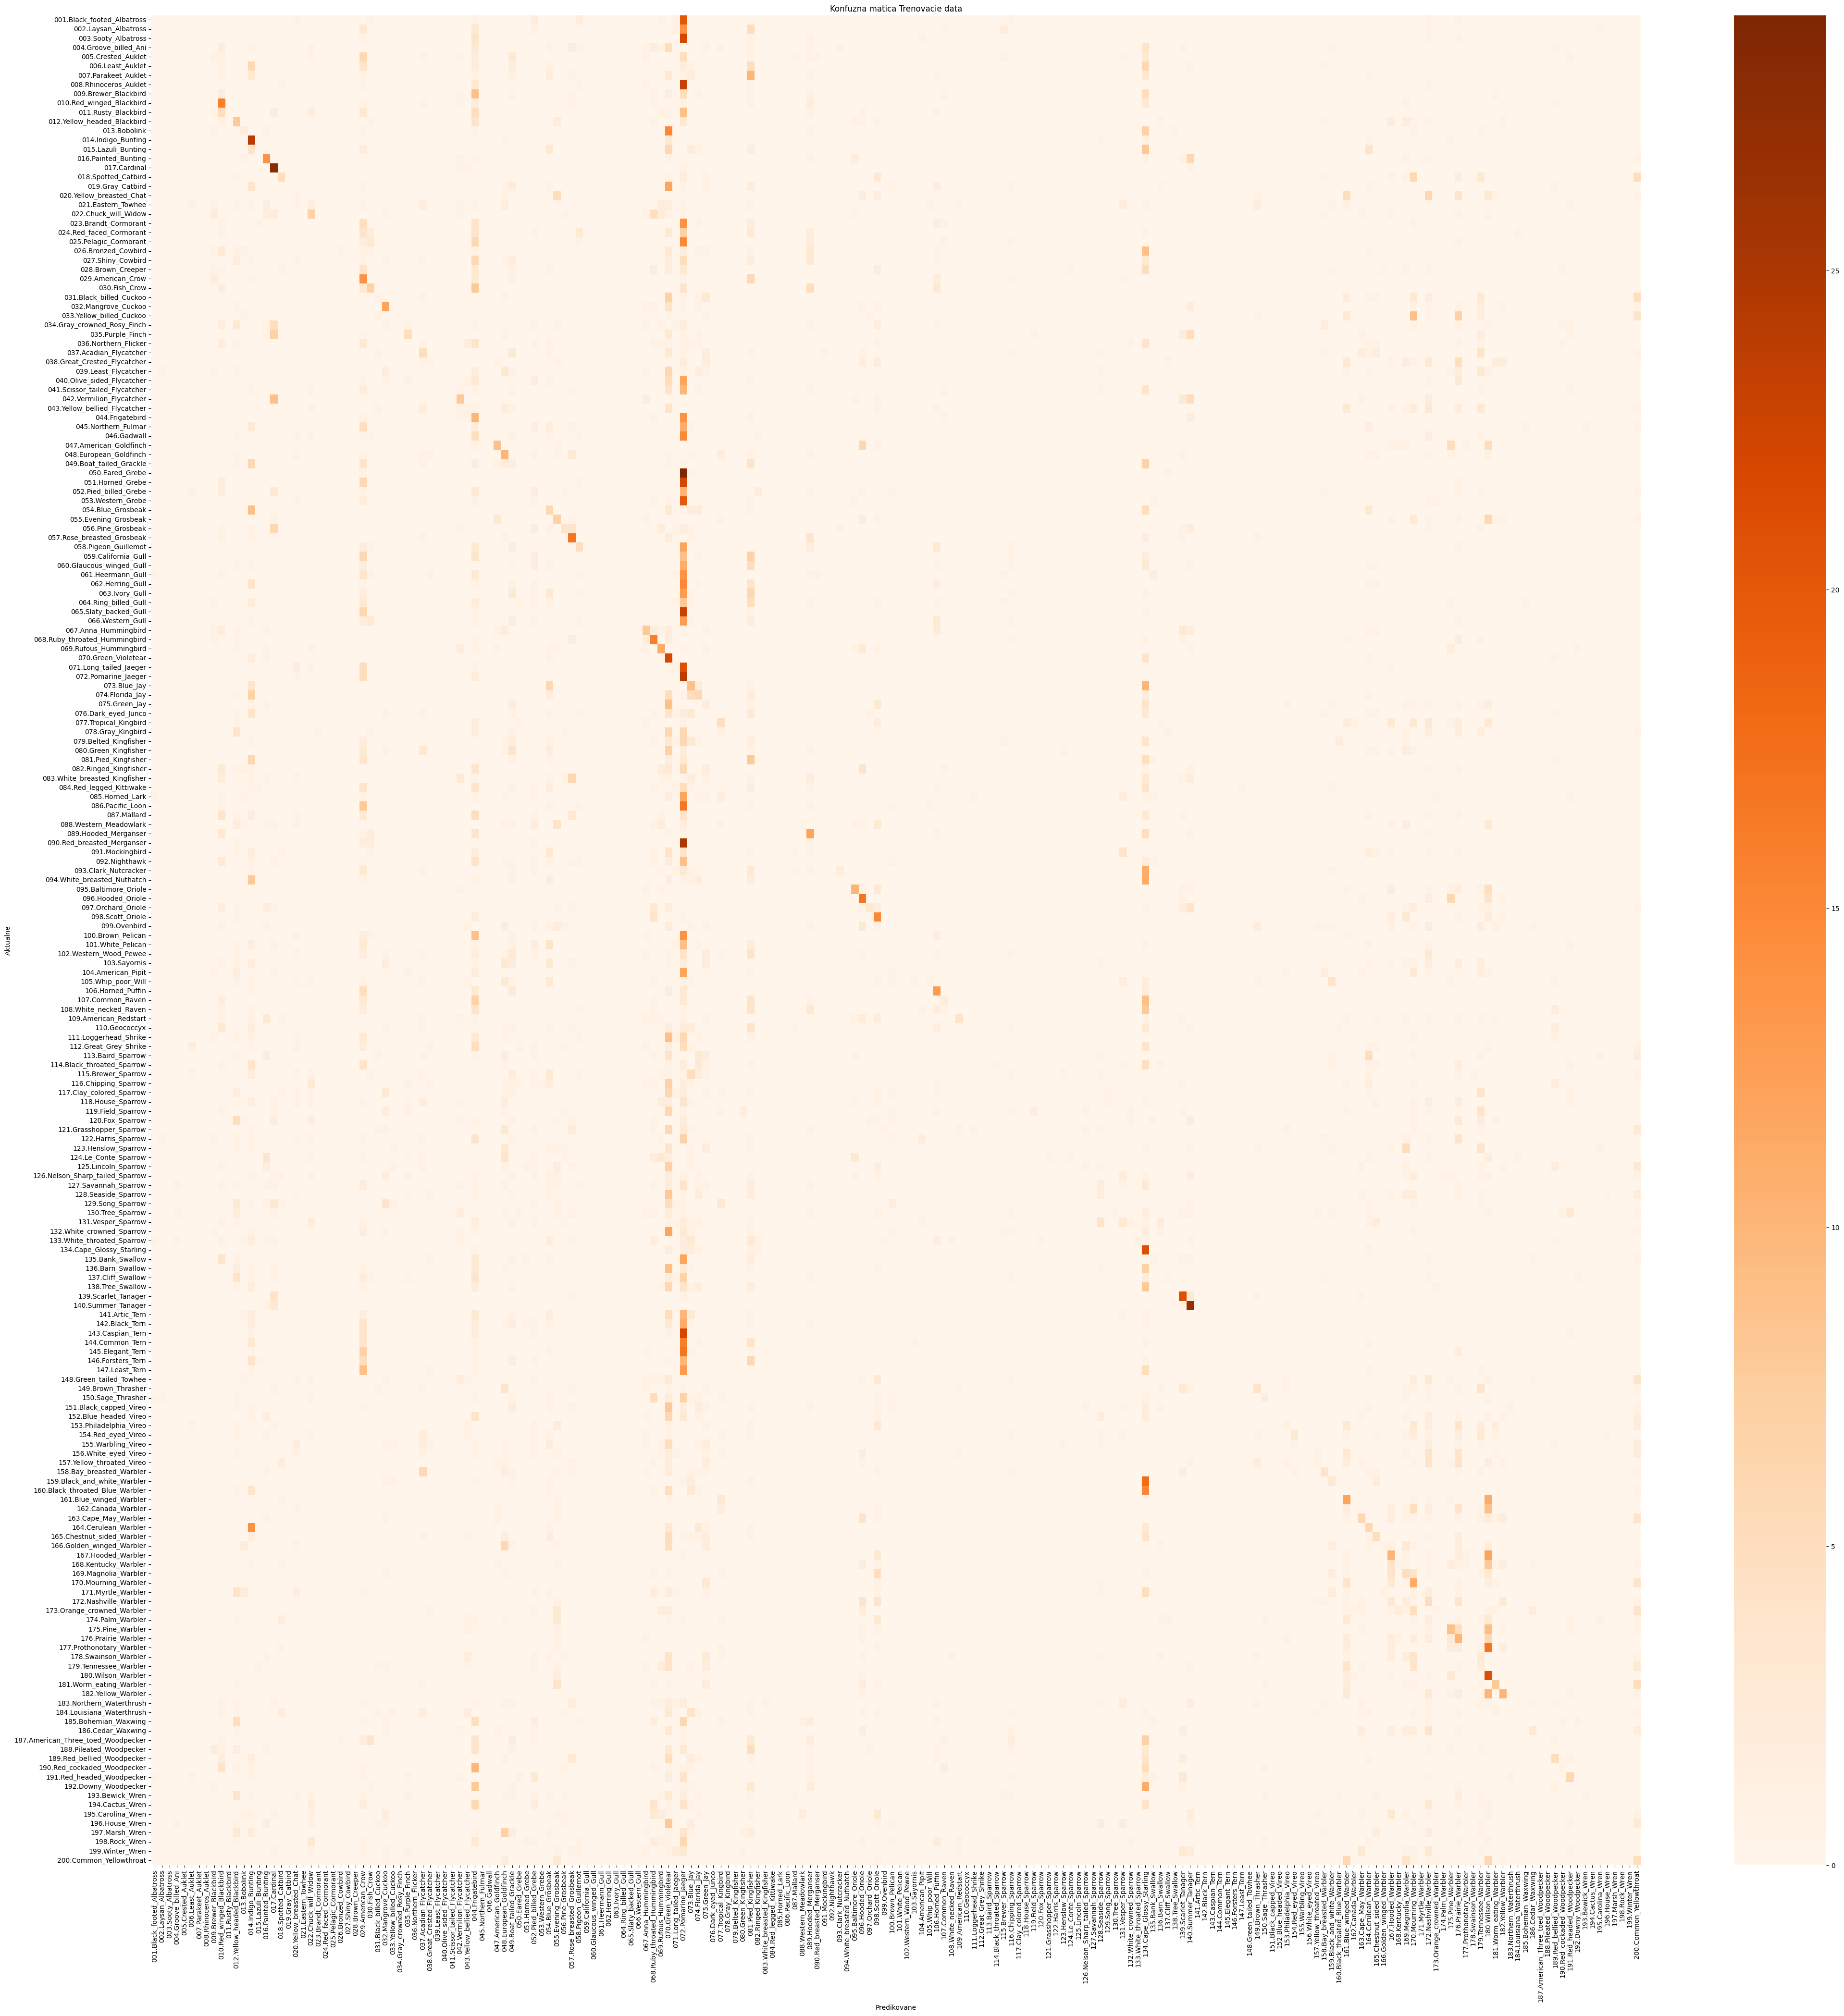

In [ ]:


y_true_classes = np.argmax(y_true, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
#plt.subplot(1,2,2)
plt.figure(figsize=(50,50))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Oranges', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Konfuzna matica Trenovacie data")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()